In [349]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import datetime as dt
import os

In [350]:
from xgboost import XGBRegressor as xgb
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [351]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error

In [352]:
sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.use_inf_as_na = True

C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\1160735233.py:3: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True


In [353]:
sales = pd.read_csv('sales_train.csv/sales_train.csv')
test = pd.read_csv('test.csv/test.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv/items.csv')
item_categories = pd.read_csv('item_categories.csv')

In [354]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [355]:
train.shape

(2935849, 10)

In [356]:
train.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1.00,1.00,-1.00,1.00,1.00
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [357]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


In [358]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [359]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   item_name           object        
 7   item_category_id    int64         
 8   shop_name           object        
 9   item_category_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 224.0+ MB


In [360]:
print(train['date'].min())
print(train['date'].max())

2013-01-01 00:00:00
2015-10-31 00:00:00


データリーク

In [361]:
test.head(0)

,ID,shop_id,item_id


In [362]:
test_shop_ids=test['shop_id'].unique()
test_item_ids=test['item_id'].unique()

# testにあるshopsのみ抽出
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# testにあるitemsのみ抽出
lk_train = train[train['item_id'].isin(test_item_ids)]

In [363]:
print(train.shape)
print(lk_train.shape)

(2935849, 10)
(1446006, 10)


In [364]:
train = lk_train

データクリーニング

In [365]:
# 返品価格を削除
train = train[train['item_price']>0]

データの前処理

カテゴリデータの削除<br>
月単位に集計

In [366]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id']]

In [367]:
train_monthly.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id'],
      dtype='object')

In [368]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'],as_index=False)
train_monthly=train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day': ['sum', 'mean', 'count']})

In [369]:
train_monthly.head()

date_block_num shop_id item_category_id item_id item_price          \
                                                         sum    mean   
0              0       0                2    5572    7932.00 1322.00   
1              0       0                2    5643   10300.00 2060.00   
2              0       0                5    5581    1221.00  407.00   
3              0       0                5    5583     734.00  367.00   
4              0       0                5    5601     412.00  412.00   

  item_cnt_day             
           sum mean count  
0        10.00 1.67     6  
1         6.00 1.20     5  
2         3.00 1.00     3  
3         2.00 1.00     2  
4         1.00 1.00     1

In [370]:
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

レコードが欠落しないように、['date_block_num','shop_id','item_id'] の考えられるすべての組み合わせを使用してデータ セットを構築

In [371]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()

empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])

empty_df = pd.DataFrame(empty_df, columns=['date_block_num', 'shop_id', 'item_id'])

In [372]:
train_monthly = pd.merge(empty_df, train_monthly, on =['date_block_num', 'shop_id', 'item_id'], how='left')
train_monthly.fillna(0, inplace=True)

In [373]:
train_monthly.shape

(9663480, 9)

In [374]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,0,5572,2.00,7932.00,1322.00,10.00,1.67,6.00
1,0,0,5643,2.00,10300.00,2060.00,6.00,1.20,5.00
2,0,0,5581,5.00,1221.00,407.00,3.00,1.00,3.00
3,0,0,5583,5.00,734.00,367.00,2.00,1.00,2.00
4,0,0,5601,5.00,412.00,412.00,1.00,1.00,1.00


In [375]:
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
count,9663480.00,9663480.00,9663480.00,9663480.00,9663480.00,9663480.00,9663480.00,9663480.00,9663480.00
mean,16.50,29.50,11079.78,3.11,152.96,65.40,0.20,0.08,0.15
std,9.81,17.32,6227.39,12.08,1985.26,474.49,3.17,0.53,0.83
min,0.00,0.00,30.00,0.00,0.00,0.00,-4.00,-2.00,0.00
25%,8.00,14.75,5460.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.50,29.50,11286.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,44.25,16090.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,59.00,22167.00,83.00,515573.59,42990.00,2253.00,1000.00,31.00


In [376]:
# 時間ベースの特徴量を抽出
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: x//12+2013 )
train_monthly['month'] =train_monthly['date_block_num'].apply(lambda x: x%12 + 1)

In [377]:
train_monthly.tail()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
9663475,33,36,9103,0.00,0.00,0.00,0.00,0.00,0.00,2015,10
9663476,33,36,9107,0.00,0.00,0.00,0.00,0.00,0.00,2015,10
9663477,33,36,5704,0.00,0.00,0.00,0.00,0.00,0.00,2015,10
9663478,33,36,12733,0.00,0.00,0.00,0.00,0.00,0.00,2015,10
9663479,33,36,15925,0.00,0.00,0.00,0.00,0.00,0.00,2015,10


EDA

In [378]:
# グルーピングデータ for EDA
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

In [379]:
print(gp_category_mean)

    item_category_id  item_cnt
0               0.00      0.00
1               2.00      2.33
2               3.00      3.09
3               5.00      1.50
4               6.00      2.96
..               ...       ...
56             76.00      7.24
57             77.00      1.52
58             78.00      1.99
59             79.00     14.56
60             83.00      4.93

[61 rows x 2 columns]


In [380]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

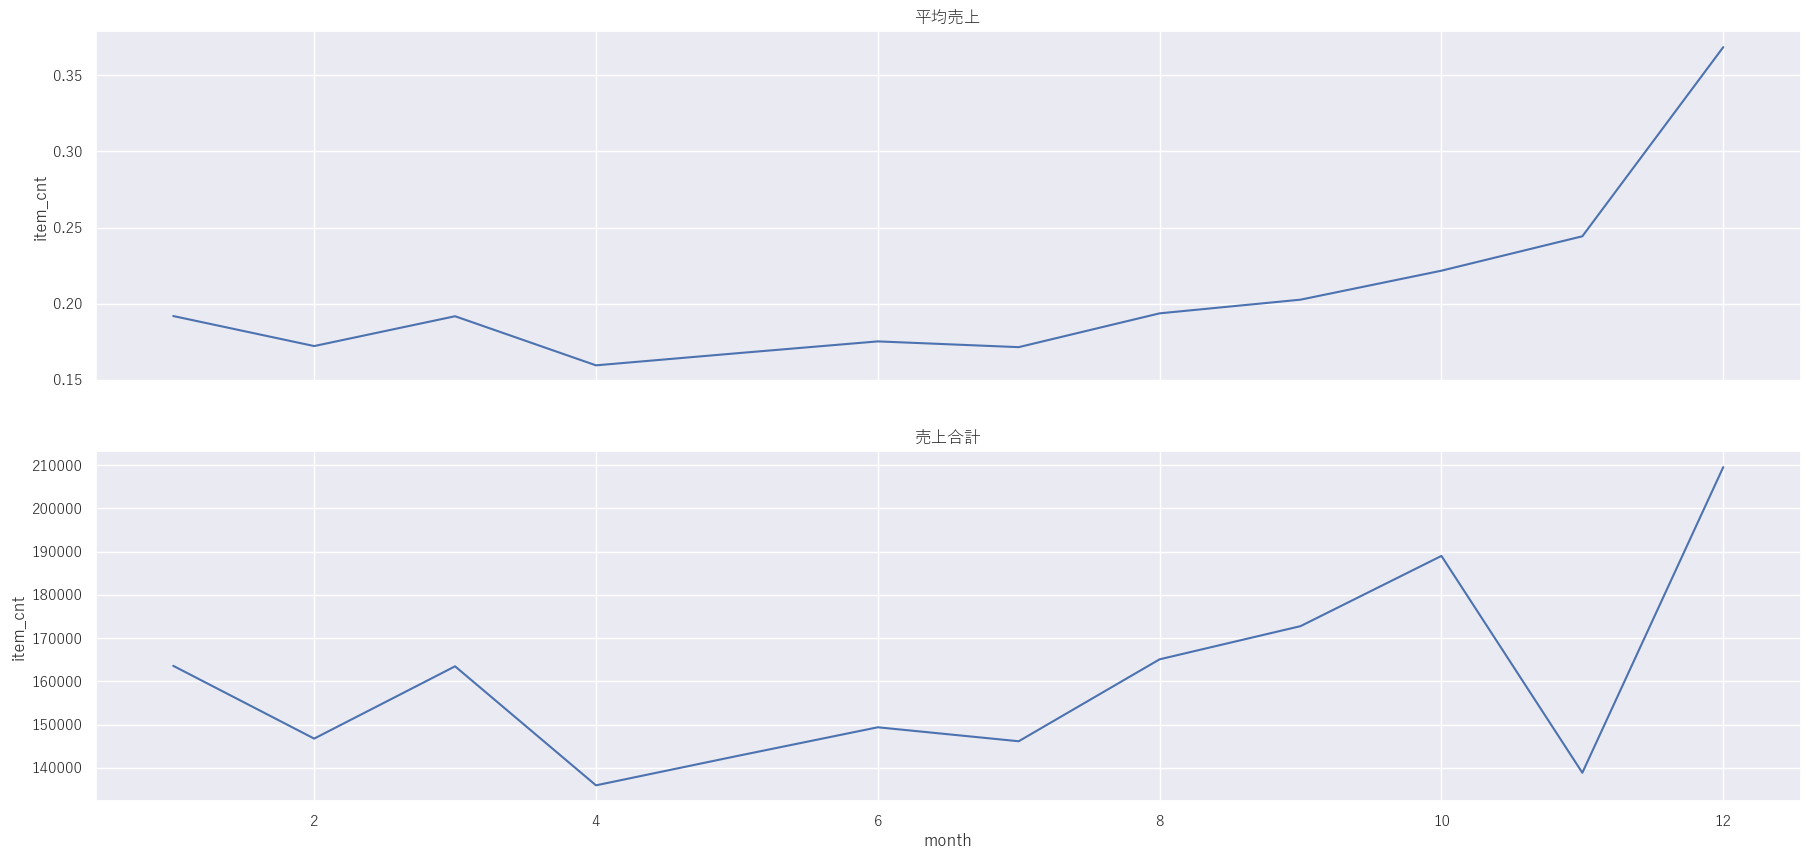

In [381]:
# 年間売上推移
fig, ax = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x='month', y='item_cnt', data= gp_month_mean, ax=ax[0]).set_title('平均売上')
sns.lineplot(x='month', y='item_cnt', data= gp_month_sum, ax=ax[1]).set_title('売上合計')
plt.show()

C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\1606685559.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_mean, ax=ax[0], palette='rocket').set_title('カテゴリ別月平均売上')
C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\1606685559.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_sum, ax=ax[1], palette='rocket').set_title('カテゴリ別月売上合計')


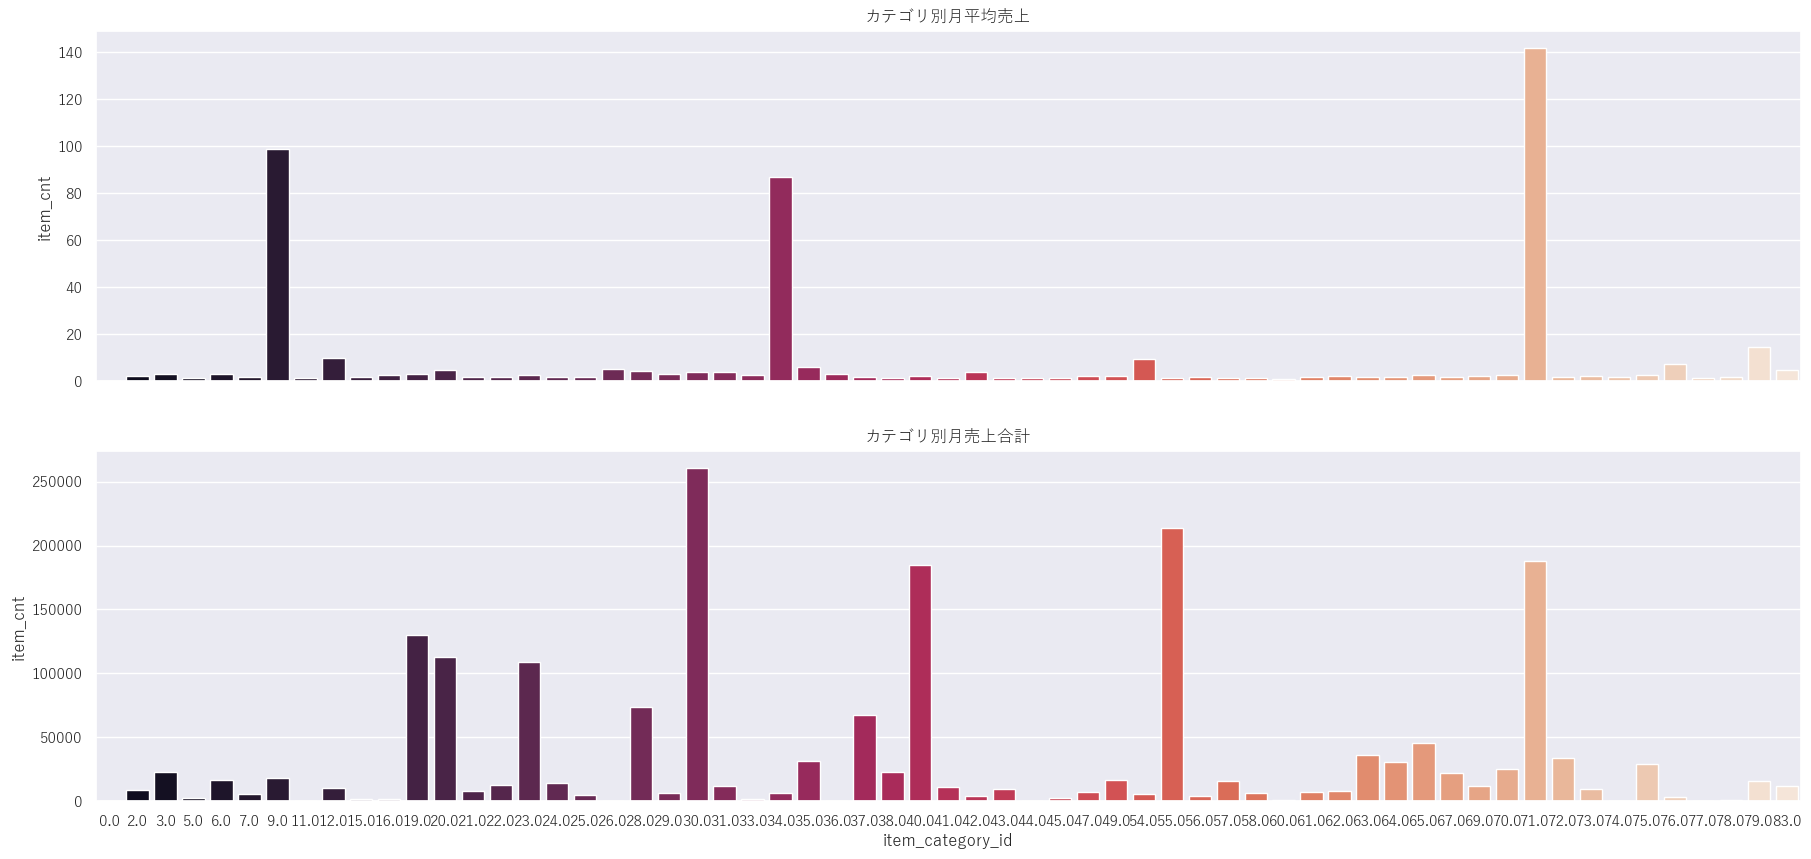

In [382]:
# カテゴリ別売上
fig, ax = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_mean, ax=ax[0], palette='rocket').set_title('カテゴリ別月平均売上')
sns.barplot(x='item_category_id', y='item_cnt', data=gp_category_sum, ax=ax[1], palette='rocket').set_title('カテゴリ別月売上合計')
plt.show()

C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\2503544444.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_sum, ax=ax[1], palette='rocket').set_title('店舗別月売上合計')


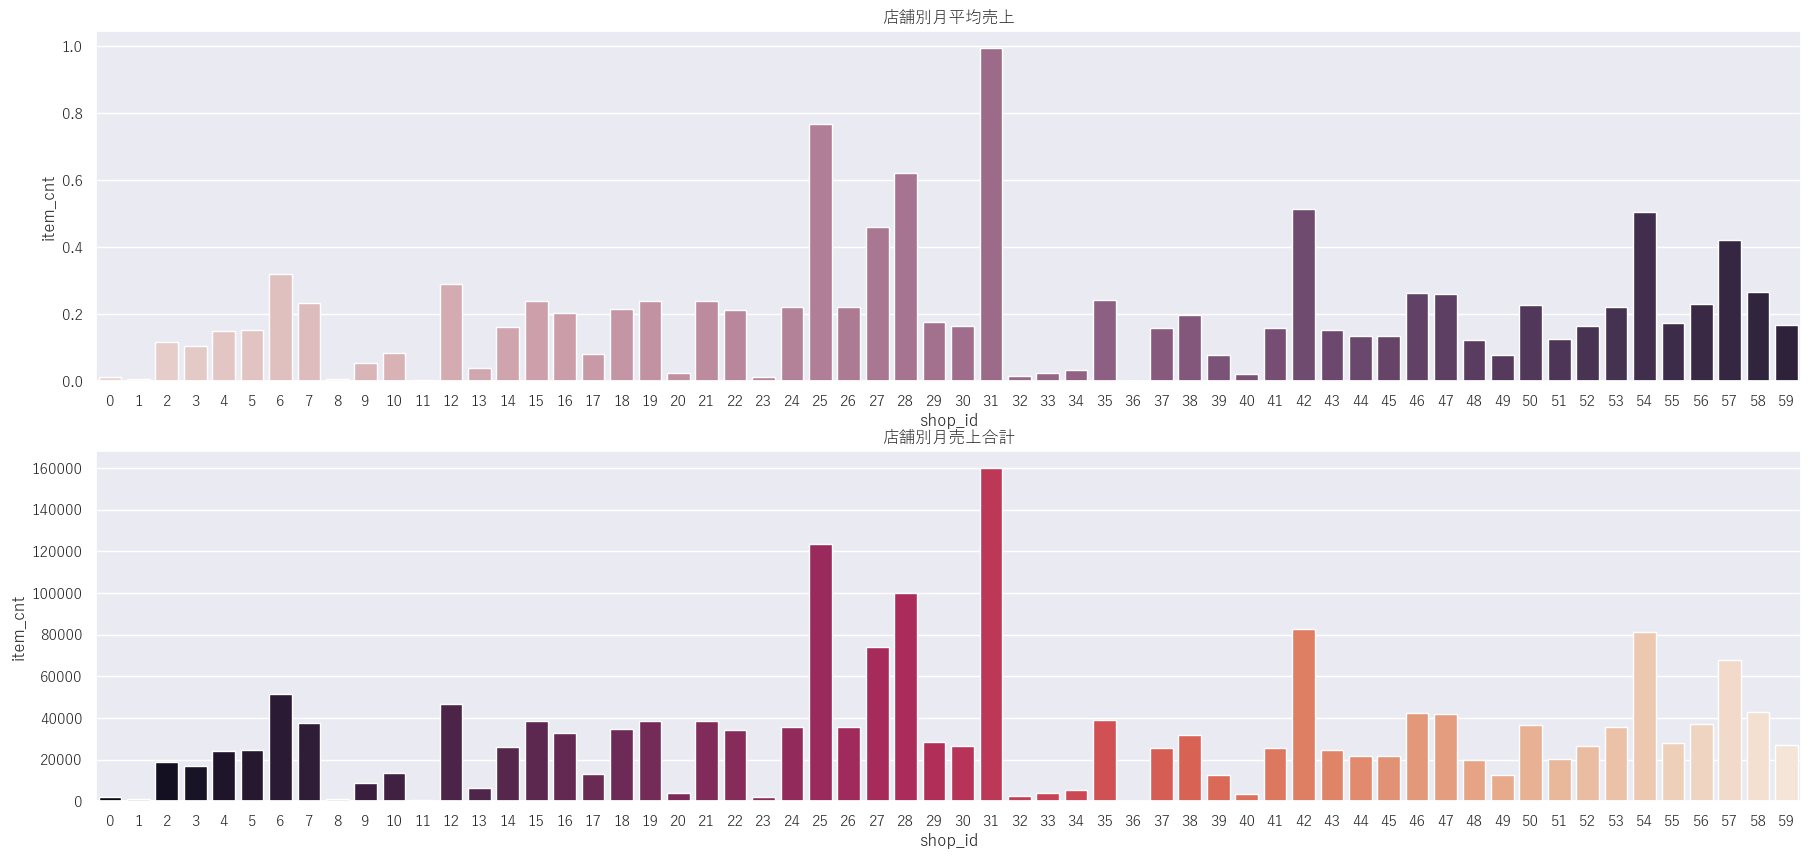

In [383]:
# 店舗別売上
fig, ax = plt.subplots(2, 1, figsize=(22, 10))
sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_mean, ax=ax[0], hue='shop_id', legend=False).set_title('店舗別月平均売上')
sns.barplot(x='shop_id', y='item_cnt', data=gp_shop_sum, ax=ax[1], palette='rocket').set_title('店舗別月売上合計')
plt.show()

外れ値のチェック

In [384]:
# sns.jointplot(x='item_cnt', y='item_price', data=train_monthly,height=8)
# plt.show()

In [385]:
# sns.jointplot(x='item_cnt', y='transactions', data=train_monthly,height=8)
# plt.show()

In [386]:
# sns.boxplot(train_monthly['item_cnt'])
# plt.show()

In [387]:
# 外れ値の削除
train_monthly = train_monthly[(train_monthly['item_cnt']>=0) & (train_monthly['item_cnt']<=20) & (train_monthly['item_price']<400000)]

翌月の売上数量のカラム作成

In [388]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

特徴量エンジニアリング

In [389]:
# 均一価格
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [390]:
# グループベースの特徴量
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\2911166292.py:2: FutureWarning: The provided callable <function min at 0x000002305FB40180> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\2911166292.py:2: FutureWarning: The provided callable <function max at 0x000002305FB40040> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})


In [391]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,0,5572,2.00,7932.00,1322.00,10.00,1.67,6.00,2013,1,11.00,793.00,0.00,18979.50
1,0,0,5643,2.00,10300.00,2060.00,6.00,1.20,5.00,2013,1,3.00,1716.00,0.00,42630.00
2,0,0,5581,5.00,1221.00,407.00,3.00,1.00,3.00,2013,1,3.00,407.00,0.00,2495.00
3,0,0,5583,5.00,734.00,367.00,2.00,1.00,2.00,2013,1,2.00,367.00,0.00,8388.00
4,0,0,5601,5.00,412.00,412.00,1.00,1.00,1.00,2013,1,0.00,412.00,0.00,3544.00


In [392]:
# 価格の変動
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

ローリングウィンドウベースの特徴量

In [393]:
train_monthly['item_cnt_min']=train_monthly['item_cnt'].rolling(window=3, min_periods=1).min()
train_monthly['item_cnt_max']=train_monthly['item_cnt'].rolling(window=3, min_periods=1).max()
train_monthly['item_cnt_mean']=train_monthly['item_cnt'].rolling(window=3, min_periods=1).mean()
train_monthly['item_cnt_std']=train_monthly['item_cnt'].rolling(window=3, min_periods=1).std()

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

ラグベースの特徴量

In [394]:
lag_list = [1, 2, 3, 6, 9, 12]

for lag in lag_list:
    ft_name =('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

販売数推移の特徴量

In [395]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list)+1

In [396]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,9655827.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,9655827.00,29.50,17.32,0.00,14.00,29.00,45.00,59.00
item_id,9655827.00,11080.62,6226.55,30.00,5460.00,11286.00,16090.00,22167.00
item_category_id,9655827.00,3.08,12.02,0.00,0.00,0.00,0.00,83.00
item_price,9655827.00,138.26,1625.87,0.00,0.00,0.00,0.00,366860.00
mean_item_price,9655827.00,64.22,465.88,0.00,0.00,0.00,0.00,42990.00
item_cnt,9655827.00,0.15,0.83,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,9655827.00,0.08,0.29,0.00,0.00,0.00,0.00,20.00
transactions,9655827.00,0.14,0.68,0.00,0.00,0.00,0.00,19.00
year,9655827.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


train/validation split

In [397]:
train_set = train_monthly[(train_monthly['date_block_num']>=12) & (train_monthly['date_block_num']<=27)]
validation_set = train_monthly[(train_monthly['date_block_num']>=28) & (train_monthly['date_block_num']<=32)]
test_set = train_monthly[train_monthly['date_block_num']==33]

In [398]:
train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\1546114575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.dropna(subset=['item_cnt_month'], inplace=True)
C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\1546114575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set.dropna(subset=['item_cnt_month'], inplace=True)


In [399]:
train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\3298742950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.dropna(inplace=True)
C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\3298742950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set.dropna(inplace=True)


平均値を特徴量に追加

In [400]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

学習データ、バリデーションデータの準備

In [401]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

テストセットの構築

In [402]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

欠損値を各項目の中央値で置き換える

In [403]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\3134402499.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
C:\Users\sinis\AppData\Local\Temp\ipykernel_15912\3134402499.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11294.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median


In [404]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

モデルの構築

XGBoost

In [410]:
df_Y_train = pd.DataFrame(Y_train)
df_Y_train.columns

Index(['item_cnt_month'], dtype='object')

In [412]:
X_train.corrwith(df_Y_train['item_cnt_month']).sort_values(ascending=False)

c:\Users\sinis\anaconda3\envs\py312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\sinis\anaconda3\envs\py312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


shop_item_mean         0.64
item_cnt               0.57
transactions           0.56
item_cnt_shifted1      0.48
item_cnt_mean          0.47
item_cnt_max           0.45
item_mean              0.43
item_cnt_std           0.43
item_cnt_shifted2      0.42
mean_item_cnt          0.41
item_cnt_shifted3      0.39
item_cnt_shifted6      0.34
item_cnt_min           0.30
item_cnt_shifted9      0.29
item_price             0.29
price_increase         0.29
mean_item_price        0.26
item_cnt_shifted12     0.25
item_price_unit        0.24
shop_mean              0.17
hist_max_item_price    0.14
price_decrease         0.10
month_mean             0.05
shop_id                0.04
month                  0.03
year_mean              0.00
year                  -0.00
item_id               -0.06
item_trend            -0.40
hist_min_item_price     NaN
dtype: float64

In [413]:
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'item_cnt_shifted6', 'item_cnt_shifted9', 'item_cnt_shifted12', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt', 'transactions', 'item_price']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [414]:
xgb_model = xgb(max_depth=5,
                n_estimators=500,
                min_child_weight=1,
                colsample_bytree=0.8,
                subsample=0.8,
                eta=0.3,
                seed=0)
xgb_model.fit(xgb_train, Y_train,
                eval_metric='rmse',
                eval_set=[(xgb_train,Y_train),(xgb_val,Y_validation)],
                verbose=20,
                early_stopping_rounds=20)

c:\Users\sinis\anaconda3\envs\py312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\sinis\anaconda3\envs\py312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.78861	validation_1-rmse:0.75149
[20]	validation_0-rmse:0.64216	validation_1-rmse:0.73478
[26]	validation_0-rmse:0.64096	validation_1-rmse:0.73661


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [417]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [418]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.6523362374751893
Validation rmse: 0.716380942941166


Random forest

In [419]:
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 
            'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
            'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [420]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, n_jobs=-1, random_state=0)

In [421]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [422]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.7004471893049854
Validation rmse: 0.6799653113481249


Linear models

In [423]:
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean', 'transactions']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [424]:
# 特徴量のスケーリング
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [425]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

In [426]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [427]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7203403975877041
Validation rmse: 0.6700539187609239


K近傍法

In [428]:
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt', 'transactions']

X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [429]:
# スケーリング
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [430]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [431]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [432]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.5363967575232735
Validation rmse: 0.7128105666098566


スタッキング

In [433]:
first_level = pd.DataFrame(xgb_val_pred, columns=['xgbm'])
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head()

,xgbm,random_forest,linear_regression,knn,label
0,0.01,0.03,0.01,0.00,0
1,0.01,0.03,0.01,0.00,0
2,0.01,0.06,0.01,0.00,0
3,0.01,0.03,0.01,0.00,0
4,0.01,0.09,0.01,0.00,0


In [434]:
first_level_test = pd.DataFrame(xgb_test_pred, columns=['xgbm'])
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,xgbm,random_forest,linear_regression,knn
0,0.46,1.21,0.81,1.11
1,0.02,0.01,0.07,0.00
2,0.24,1.52,1.51,0.56
3,0.07,0.09,0.07,0.00
4,0.02,0.01,0.07,0.00


第2レベルモデルとして線形回帰を使用

In [435]:
meta_model = LinearRegression(n_jobs=-1)

In [436]:
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(n_jobs=-1)

In [437]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [438]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.6659975832506061


ファイルの提出

In [439]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head()

,ID,item_cnt_month
0,0,0.88
1,1,0.05
2,2,1.29
3,3,0.07
4,4,0.05


In [441]:
prediction_df.shape

(214200, 2)